This is the main piece of code for finding time resolution. Look around there is a variety of ways to do ittho the last two are the best and most efficenct. This is the most complex thing here so dont be afraid to reach out to sidney.niven.shapiro@gmail.com or sshapiro@triumf.ca

### Imports and global size parameters so mike can see it

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
from scipy.optimize import curve_fit, minimize
from scipy.signal import fftconvolve
import numpy as np
plt.rcParams.update({
    'font.size': 16,          # Global default font size
    'axes.titlesize': 16,     # Title font size
    'axes.labelsize': 16,     # Axis label font size
    'xtick.labelsize': 16,    # X tick size
    'ytick.labelsize': 16,    # Y tick size
    'legend.fontsize': 13,    # Legend font size
})

### Every function for the main fitting

In [2]:
# --- Gaussian model ---
def gaussian(x, amp, mean, sigma):
    return amp * np.exp(-0.5 * ((x - mean) / sigma) ** 2)

def get_initial_guess_gaussian(x, y, side=None):
    amp = np.max(y)
    mean = x[np.argmax(y)]
    half_max = amp / 2
    indices = np.where(y > half_max)[0]

    if len(indices) >= 2:
        fwhm = x[indices[-1]] - x[indices[0]]
    else:
        fwhm = (x[-1] - x[0]) / 2.0

    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))

    # Adjust mean based on side to lie within the bounds
    if side == "left":
        mean = max(x) + 0.1 * (max(x) - min(x))
    elif side == "right":
        mean = min(x) - 0.1 * (max(x) - min(x))

    return [amp, mean, sigma]


def fit_single_gaussian(x, y, side="left"):
    p0 = get_initial_guess_gaussian(x, y,side=side)
    yerr = np.sqrt(np.clip(y, 1, None))
    
    # Apply constraints on mean depending on which side we are fitting
    if side == "left":
        bounds = ([0, max(x), 0], [np.inf, np.inf, np.inf])  # mean > max(x)
    elif side == "right":
        bounds = ([0, -np.inf, 0], [np.inf, min(x), np.inf])  # mean < min(x)
    else:
        raise ValueError("side must be 'left' or 'right'")

    popt, pcov = curve_fit(gaussian, x, y, sigma=yerr, absolute_sigma=True, p0=p0, bounds=bounds)
    y_fit = gaussian(x, *popt)
    residuals = y - y_fit
    chi2 = np.sum((residuals / yerr) ** 2)
    dof = len(x) - len(popt)
    chi2_red = chi2 / dof
    sigma = popt[2]
    sigma_err = np.sqrt(pcov[2, 2]) if np.isfinite(pcov[2, 2]) else np.nan
    return popt, sigma, sigma_err, chi2, chi2_red, y_fit, residuals, yerr


def fit_two_flanks_gaussian(x_flank_g, y_flank_g, plot_name_prefix=None,return_all = False):
    x_center = np.mean(x_flank_g)
    left_mask = x_flank_g < x_center
    right_mask = x_flank_g > x_center

    x_left, y_left = x_flank_g[left_mask], y_flank_g[left_mask]
    x_right, y_right = x_flank_g[right_mask], y_flank_g[right_mask]

    # Fit each side
    fit_left = fit_single_gaussian(x_left, y_left, side="left")
    fit_right = fit_single_gaussian(x_right, y_right, side="right")

    # Unpack
    _, sigma_l, sigma_err_l, chi2_l, chi2red_l, y_fit_l, res_l, yerr_l = fit_left
    _, sigma_r, sigma_err_r, chi2_r, chi2red_r, y_fit_r, res_r, yerr_r = fit_right

    # Average resolution
    sigma_avg = (sigma_l + sigma_r) / 2
    sigma_avg_err = np.sqrt((sigma_err_l ** 2 + sigma_err_r ** 2) / 4)

    # Print results
    print("--- Two-Gaussian Flank Fit ---")
    print(f"Left  σ = {sigma_l:.4f} ± {sigma_err_l:.4f}, χ²/ν = {chi2red_l:.2f}")
    print(f"Right σ = {sigma_r:.4f} ± {sigma_err_r:.4f}, χ²/ν = {chi2red_r:.2f}")
    print(f"\nAverage Timing Resolution: σ = {sigma_avg:.4f} ± {sigma_avg_err:.4f} ns")

    # --- Plot Fit ---
    plt.figure(figsize=(10, 5))
    plt.errorbar(x_left, y_left, yerr=yerr_l, fmt='o', elinewidth=3, label="Left Flank", color='m', alpha=1)
    plt.plot(x_left, y_fit_l, label="Fit Left", color='m')
    plt.errorbar(x_right, y_right, yerr=yerr_r, fmt='o', color='tab:orange',elinewidth=3, label="Right Flank", alpha=1)
    plt.plot(x_right, y_fit_r, label="Fit Right", color='tab:orange')
    plt.plot(x_root_cut, countsChopped_cut, "k--", label="Full Distribution")
    plt.title("Two-Gaussian Flank Fits")
    plt.xlabel("Time difference (ns)")
    plt.ylabel("Counts")
    plt.legend()
    plt.grid(True, linestyle=':')
    plt.tight_layout()
    if plot_name_prefix:
        plt.savefig(f"{plot_name_prefix}_fit.jpg", dpi=300)
    plt.show()

    # --- Residuals ---
    plt.figure(figsize=(10, 4))
    plt.axhline(0, color='black', linestyle='--')
    plt.errorbar(x_left, res_l, yerr=yerr_l, fmt='o', markersize=4, label="Residuals Left", alpha=0.7)
    plt.errorbar(x_right, res_r, yerr=yerr_r, fmt='o', markersize=4, label="Residuals Right", alpha=0.7)
    plt.title("Residuals of Two-Gaussian Flank Fits")
    plt.xlabel("Time difference (ns)")
    plt.ylabel("Residual (Data - Fit)")
    plt.legend()
    plt.grid(True, linestyle=':')
    plt.tight_layout()
    if plot_name_prefix:
        plt.savefig(f"{plot_name_prefix}_residuals.jpg", dpi=300)
    plt.show()

    if return_all:
        return sigma_avg, sigma_avg_err, sigma_l, sigma_err_l, chi2red_l, sigma_r, sigma_err_r, chi2red_r
    return sigma_avg, sigma_avg_err

def get_flank_mask_yonly(x, y, threshold_frac=0.95):
    """
    Return a mask for the flanks by removing only the top (flat) region.
    threshold_frac: fractional height of max(y) to define top to exclude
    """
    y = np.array(y)
    y_max = np.max(y)
    return y < (threshold_frac * y_max)
def get_flank_mask_slope_based(x, y, buffer_bins=2, slope_threshold_frac=0.1):
    """
    Create a mask that captures the falling edges (flanks) of the square wave
    using the derivative to find transition zones.
    
    buffer_bins: how many bins to keep around each flank
    slope_threshold_frac: fraction of max slope used to detect edge regions
    """
    x = np.array(x)
    y = np.array(y)

    dy = np.gradient(y, x)
    dy_abs = np.abs(dy)
    slope_max = np.max(dy_abs)
    slope_thresh = slope_threshold_frac * slope_max

    # Find where slope exceeds threshold — this gives flank zones
    flank_indices = np.where(dy_abs > slope_thresh)[0]

    # Initialize mask to all False
    mask = np.zeros_like(y, dtype=bool)

    # Turn on buffer regions around detected slopes
    for idx in flank_indices:
        start = max(0, idx - buffer_bins)
        end = min(len(y), idx + buffer_bins + 1)
        mask[start:end] = True

    return mask
def fit_gaussian_flanks(x, y, yerr, p0, buffer_bins=5, slope_threshold_frac=0.05):
    """
    Fit only the flanks of the data with a plain Gaussian (no convolution).
    """
    x = np.array(x)
    y = np.array(y)
    yerr = np.array(yerr)

    mask = get_flank_mask_slope_based(x, y, buffer_bins=buffer_bins, slope_threshold_frac=slope_threshold_frac)
    x_flank = x[mask]
    y_flank = y[mask]
    yerr_flank = yerr[mask]

    from scipy.optimize import curve_fit
    popt, pcov = curve_fit(gaussian, x_flank, y_flank, sigma=yerr_flank, absolute_sigma=True, p0=p0)

    y_fit = gaussian(x_flank, *popt)
    residuals = y_flank - y_fit
    chi2 = np.sum((residuals / yerr_flank) ** 2)
    dof = len(x_flank) - len(popt)
    chi2_red = chi2 / dof

    return popt, pcov, chi2, chi2_red, x_flank, y_flank, y_fit

def scan_slope_flank_grid(x, y, yerr, func, p0, buffer_vals, slope_vals):
    """
    Grid search for best fit quality using slope-based flank masking.
    
    Parameters:
    - x, y, yerr: input data arrays
    - func: model function (e.g. convolve_fixed_1gauss)
    - p0: initial parameter guess
    - buffer_vals: list of buffer_bins to scan
    - slope_vals: list of slope_threshold_frac values to scan

    Returns:
    - results: list of (buffer, slope_thresh, sigma, chi2_red)
    """
    results = []
    for buffer in buffer_vals:
        for slope in slope_vals:
            try:
                popt, chi2, chi2_red, _, _, _ = fit_chopped_1gauss_flanks(
                    x, y, yerr, func, p0,
                    buffer_bins=buffer,
                    slope_threshold_frac=slope
                )
                sigma = popt[3]
                results.append((buffer, slope, sigma, chi2_red))
            except:
                results.append((buffer, slope, None, None))
    return results


### File reading(due it whenever you want different data)

In [3]:
# how to open a root file in python
# Edit this here to run on any file
with uproot.open("/Users/sidne/DarkLight 2025/output00358.root") as f:
    fileID = "dltdc8_pair2_t_02_10_ns_cut"
    folder = "dltdc8"
    timeDiff = f[folder][fileID].to_numpy()[0] #y data
    #t14 = f["dltdc"]["t14ns_1458"].to_numpy()[0]
    #t58 = f["dltdc"]["t58ns_1458"].to_numpy()[0]
    #t23 = f["dltdc"]["t23ns_2367"].to_numpy()[0]
    #t67 = f["dltdc"]["t67ns_2367"].to_numpy()[0]
    x_root = f[folder][fileID].to_numpy()[1][0:-1] #x data
    
    timeDiff_firstHalf = timeDiff[0:int(len(timeDiff)/2)]
    timeDiff_lastHalf = timeDiff[int(len(timeDiff)/2):-1]

    
    #Store index where the data is 10% of the max value for that portion of data
    first10pmaxIndex = 0
    last10pmaxIndex = 0
    threshold = 0.15 #Proportion of the max we want to cut at (choose data greater than this proportion of the max)
    foundMax = 0 #Switch to be changed once we find the point crossing the threshold of the max of that part of the data
    i = 0
    j = 0

    while (foundMax == 0) and (i < len(timeDiff_firstHalf)):
        
        if timeDiff_firstHalf[i] > threshold*max(timeDiff_firstHalf):
            first10pmaxIndex = i
            foundMax = 1            
        i = i+1
        
    while (foundMax != 2) and (j < len(timeDiff_lastHalf)):
        
        if timeDiff_lastHalf[len(timeDiff_lastHalf) - 1 - j] > threshold*max(timeDiff_lastHalf):
            last10pmaxIndex = len(timeDiff_lastHalf) - 1 - j
            foundMax = 2            
        j = j+1
            
    #Cut data
    timeDiff_cut = timeDiff[first10pmaxIndex:len(timeDiff_firstHalf)+last10pmaxIndex]
    x_root_cut = x_root[first10pmaxIndex:len(timeDiff_firstHalf)+last10pmaxIndex]
    
    #Calculate y error bars
    y_err = []
    for i in range(len(timeDiff)):
        y_err.append(np.sqrt(timeDiff[i]))
        
    y_err_cut = []
    for i in range(len(timeDiff_cut)):
        y_err_cut.append(np.sqrt(timeDiff_cut[i]))
        
        
    # NEW FOR CHOPPING OFF THE TOP
    peakHeight = max(timeDiff_cut)
    countsChopped_cut = np.zeros(len(timeDiff_cut))
    countsChopped_cut.tolist()
    
    for i in range(len(timeDiff_cut)):
        if timeDiff_cut[i]>((1-threshold)*peakHeight):
            countsChopped_cut[i] = (1-threshold)*peakHeight
        
        else:
            countsChopped_cut[i] = timeDiff_cut[i]
                  
#plt.plot(x_root_cut,timeDiff_cut)


### Example Run of data

--- Two-Gaussian Flank Fit ---
Left  σ = 0.4310 ± 0.0086, χ²/ν = 0.87
Right σ = 0.9054 ± 0.0179, χ²/ν = 116.86

Average Timing Resolution: σ = 0.6682 ± 0.0099 ns


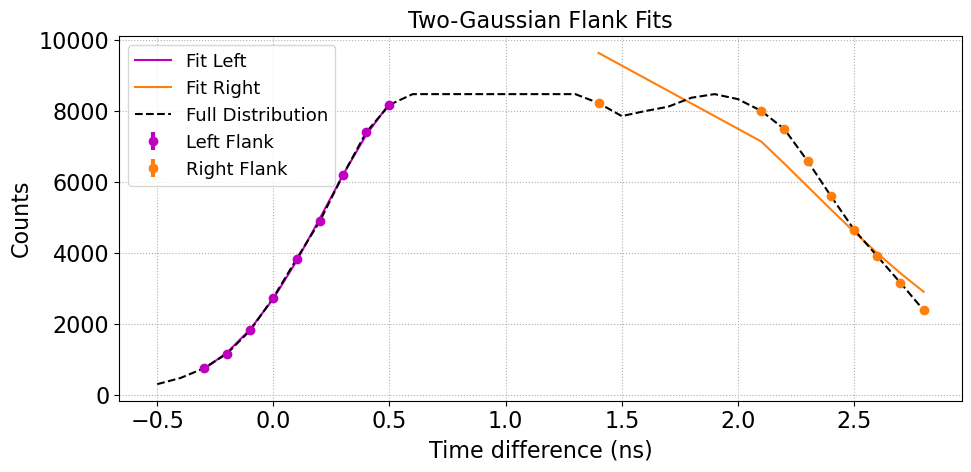

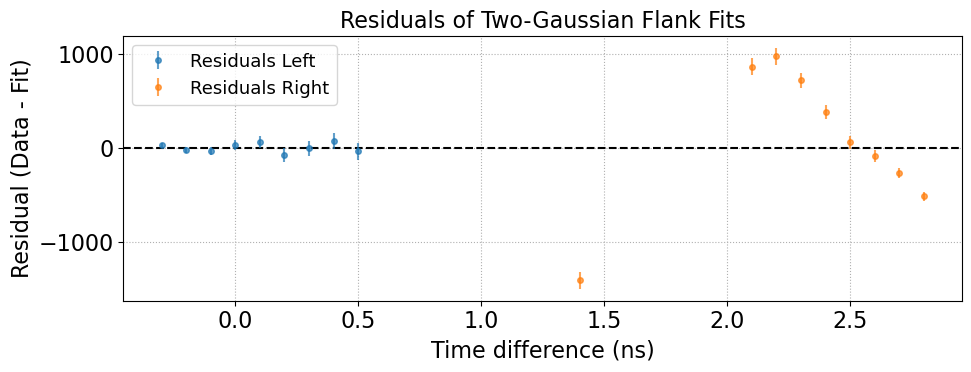

(0.6682269452213478, 0.00994897296150871)

In [4]:
flank_mask = get_flank_mask_slope_based(x_root_cut, countsChopped_cut, buffer_bins=0, slope_threshold_frac=0.245)
x_flank_g = x_root_cut[flank_mask]
y_flank_g = countsChopped_cut[flank_mask]

fit_two_flanks_gaussian(x_flank_g, y_flank_g)

### Data Demonstrator

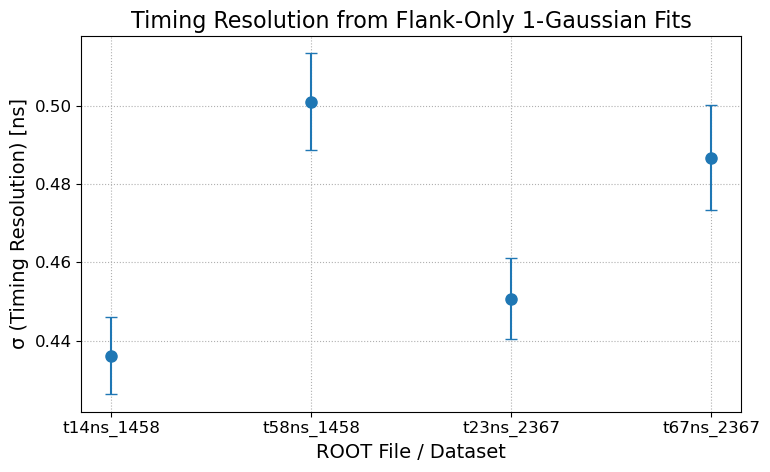

In [5]:


file_names = ["t14ns_1458", "t58ns_1458", "t23ns_2367", "t67ns_2367"]
timing_sigmas = [0.4362, 0.5011, 0.4508, 0.4868]  # from flank fits



timing_errors = [0.0099, 0.0123, 0.0103, 0.0135]  # same length as timing_sigmas

plt.figure(figsize=(8, 5))

# Scatter with vertical error bars only, no lines between points
plt.errorbar(file_names, timing_sigmas, yerr=timing_errors, fmt='o',
             markersize=8, capsize=4, elinewidth=1.5, color='tab:blue')

# Labels and formatting
plt.ylabel("σ (Timing Resolution) [ns]", fontsize=14)
plt.xlabel("ROOT File / Dataset", fontsize=14)
plt.title("Timing Resolution from Flank-Only 1-Gaussian Fits", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle=':')

plt.tight_layout()
plt.show()


### Auto fit system tob find optimal threshold

In [6]:
def auto_fit_two_flanks_gaussian(
    x_cut,
    y_cut,
    initial_thresh=0.05,
    buffer_bins=1,
    max_iterations=10,
    verbose=True
):
    """
    Try different slope thresholds to find the best 2-flank Gaussian fit.
    Returns best (popt1, popt2, sigma_avg, chi2red_total, slope_threshold_used)
    """
    slope_thresh = initial_thresh
    best_result = None
    best_chi2red = np.inf

    for _ in range(max_iterations):
        flank_mask = get_flank_mask_slope_based(x_cut, y_cut, buffer_bins, slope_thresh)
        x_flank = x_cut[flank_mask]
        y_flank = y_cut[flank_mask]

        if len(x_flank) < 6:
            if verbose:
                print(f"[!] Too few flank points at slope_thresh={slope_thresh:.3f}")
            slope_thresh += 0.01
            continue

        midpoint = np.average(x_flank, weights=y_flank)
        left_mask = x_flank < midpoint
        right_mask = x_flank >= midpoint

        if np.sum(left_mask) < 3 or np.sum(right_mask) < 3:
            if verbose:
                print(f"[!] Too few points on one side at slope_thresh={slope_thresh:.3f}")
            slope_thresh += 0.01
            continue

        try:
            popt1, _, _, chi2_1, _, _, _, _ = fit_single_gaussian(x_flank[left_mask], y_flank[left_mask], side="left")
            popt2, _, _, chi2_2, _, _, _, _ = fit_single_gaussian(x_flank[right_mask], y_flank[right_mask], side="right")
            chi2_comb = chi2_1 + chi2_2
            dof = (len(x_flank[left_mask]) + len(x_flank[right_mask])) - 6
            chi2red_comb = chi2_comb / dof

            if verbose:
                print(f"[✓] slope_thresh = {slope_thresh:.3f} → χ²/ν = {chi2red_comb:.2f}")

            if chi2red_comb < best_chi2red:
                sigma_avg = 0.5 * (popt1[2] + popt2[2])
                best_result = (popt1, popt2, sigma_avg, chi2red_comb, slope_thresh)
                best_chi2red = chi2red_comb

        except Exception as e:
            if verbose:
                print(f"[!] Fit error at slope_thresh={slope_thresh:.3f}: {e}")

        slope_thresh += 0.01

    if best_result is not None:
        if verbose:
            print(f"[✓] Best result: χ²/ν = {best_result[3]:.2f} at slope_thresh = {best_result[4]:.3f}")
        return best_result
    else:
        if verbose:
            print("[X] All fits failed.")
        return None, None, None, None, None



=== Processing: dltdc16_sc01_t_01_09_ns_cut_twc ===


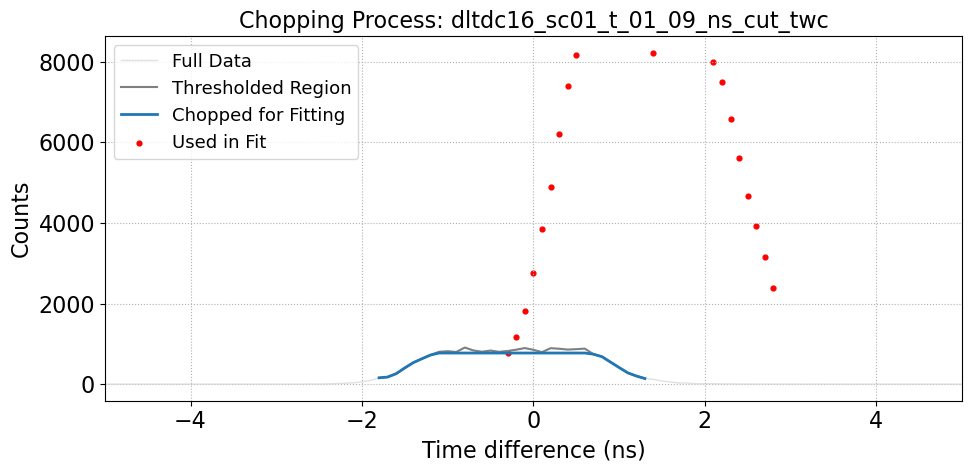

[✓] slope_thresh = 0.025 → χ²/ν = 1.55
[✓] slope_thresh = 0.035 → χ²/ν = 1.55
[✓] slope_thresh = 0.045 → χ²/ν = 1.55
[✓] slope_thresh = 0.055 → χ²/ν = 1.55
[✓] slope_thresh = 0.065 → χ²/ν = 1.55
[✓] slope_thresh = 0.075 → χ²/ν = 1.55
[✓] slope_thresh = 0.085 → χ²/ν = 1.55
[✓] slope_thresh = 0.095 → χ²/ν = 1.55
[✓] slope_thresh = 0.105 → χ²/ν = 1.64
[✓] slope_thresh = 0.115 → χ²/ν = 1.64
[✓] slope_thresh = 0.125 → χ²/ν = 1.64
[✓] slope_thresh = 0.135 → χ²/ν = 1.64
[✓] slope_thresh = 0.145 → χ²/ν = 1.64
[✓] slope_thresh = 0.155 → χ²/ν = 0.54
[✓] slope_thresh = 0.165 → χ²/ν = 0.54
[✓] slope_thresh = 0.175 → χ²/ν = 0.54
[✓] slope_thresh = 0.185 → χ²/ν = 0.58
[✓] slope_thresh = 0.195 → χ²/ν = 0.58
[✓] slope_thresh = 0.205 → χ²/ν = 0.58
[✓] slope_thresh = 0.215 → χ²/ν = 0.58
[✓] slope_thresh = 0.225 → χ²/ν = 0.58
[✓] slope_thresh = 0.235 → χ²/ν = 0.58
[✓] slope_thresh = 0.245 → χ²/ν = 0.58
[✓] slope_thresh = 0.255 → χ²/ν = 0.58
[✓] slope_thresh = 0.265 → χ²/ν = 0.58
[✓] slope_thresh = 0.275 

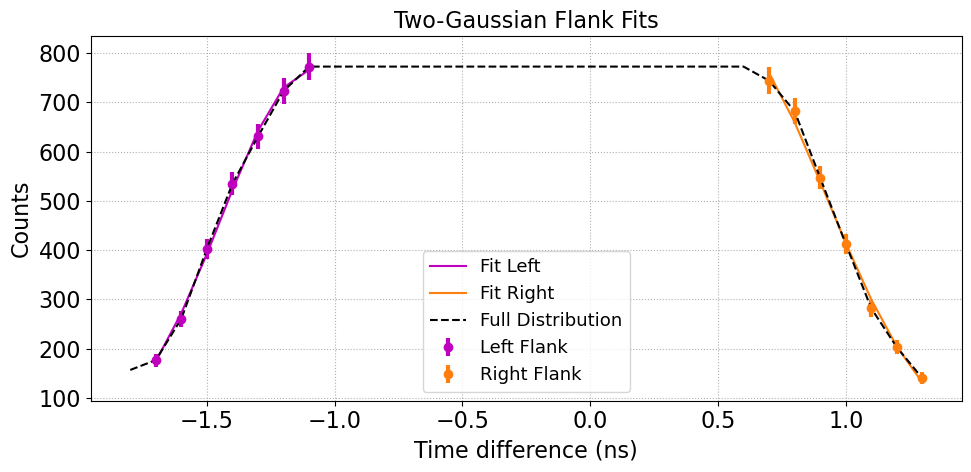

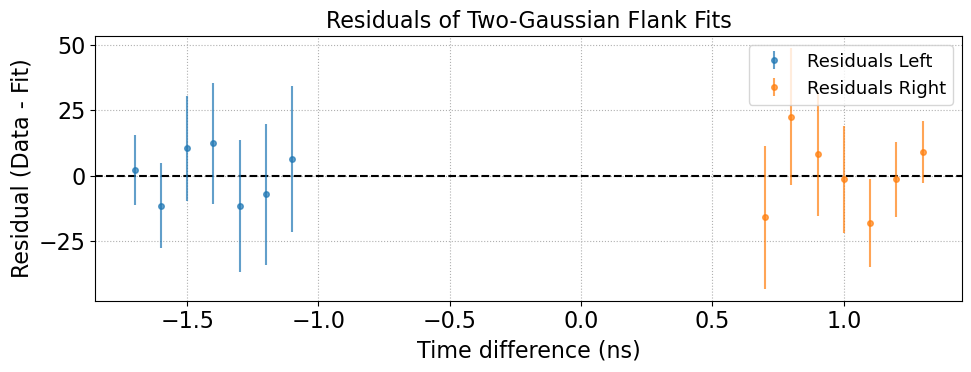

📁 Results saved to 'timing_resolution_results_00368.csv'


In [7]:
import pandas as pd
import uproot
import numpy as np

histogram_names = ["dltdc16_sc01_t_01_09_ns_cut_twc"]
results = []
buffer_bins = 0 ### 
rootPath = "/Users/sidne/DarkLight 2025/"
threshold = 0.15
runNumber = "00368"
with uproot.open(rootPath + "output" + runNumber + ".root") as f:
    folder = "dltdc16"

    for fileID in histogram_names:
        print(f"\n=== Processing: {fileID} ===")
        timeDiff = f[folder][fileID].to_numpy()[0]
        x_root = f[folder][fileID].to_numpy()[1][:-1]

        # Skip empty histograms
        if np.sum(timeDiff) == 0:
            print(f"⚠️ Skipping {fileID}: histogram is empty.")
            continue

        global_max = np.max(timeDiff)
        first = next((i for i, y in enumerate(timeDiff) if y > threshold * global_max), None)
        last = next((i for i, y in enumerate(timeDiff[::-1]) if y > threshold * global_max), None)
        last = len(timeDiff) - 1 - last if last is not None else None

        if first is None or last is None:
            print(f"⚠️ Skipping {fileID}: Could not find threshold crossings in one or both halves.")
            continue

        x_root_cut = x_root[first:last + 1]
        timeDiff_cut = timeDiff[first:last + 1]
        y_err_cut = np.sqrt(np.clip(timeDiff_cut, 1, None))
        peakHeight = max(timeDiff_cut)
        countsChopped_cut = np.minimum(timeDiff_cut, (1 - threshold) * peakHeight)
    # Plot original vs chopped data
        # Plot full original, cut, and chopped data
        plt.figure(figsize=(10, 5))

        # Full original histogram
        plt.plot(x_root, timeDiff, label="Full Data", color='lightgray', linewidth=1.0, alpha=0.7)

        # Cut region
        plt.plot(x_root_cut, timeDiff_cut, label="Thresholded Region", color='gray', linewidth=1.5)

        # Chopped region
        plt.plot(x_root_cut, countsChopped_cut, label="Chopped for Fitting", color='tab:blue', linewidth=2)

        # Final points used for flank fitting
        plt.scatter(x_flank_g, y_flank_g, color='red', s=12, label="Used in Fit")

        plt.title(f"Chopping Process: {fileID}")
        plt.xlabel("Time difference (ns)")
        plt.ylabel("Counts")
        plt.xlim(-5, 5)
        plt.legend()
        plt.grid(True, linestyle=':')
        plt.tight_layout()
        plt.show()

        result = auto_fit_two_flanks_gaussian(
            x_root_cut,
            countsChopped_cut,
            initial_thresh=0.025,
            buffer_bins=buffer_bins,
            max_iterations=30,
            verbose=True
        )

        if result[0] is not None:
            _, _, sigma_avg, chi2red, best_thresh = result
            print(f"✅ Best result for {fileID}:")
            print(f"   σ = {sigma_avg:.4f} ns")
            print(f"   χ²/ν = {chi2red:.2f}")
            print(f"   slope threshold = {best_thresh:.3f}")

            # Run final fit with best slope threshold
            flank_mask = get_flank_mask_slope_based(
                x_root_cut, countsChopped_cut,
                buffer_bins=buffer_bins,
                slope_threshold_frac=best_thresh
            )
            x_flank_g = x_root_cut[flank_mask]
            y_flank_g = countsChopped_cut[flank_mask]
        
            sigma_avg, sigma_avg_err, sigma_l, sigma_err_l, chi2red_l, sigma_r, sigma_err_r, chi2red_r = fit_two_flanks_gaussian(
                x_flank_g, y_flank_g, return_all=True
            )

            results.append([
                fileID,
                sigma_avg, sigma_avg_err,
                sigma_r, sigma_err_r, chi2red_r,
                sigma_l, sigma_err_l, chi2red_l
            ])
        else:
            print(f"❌ No acceptable fit found for {fileID}")

    # Save results to CSV
    df = pd.DataFrame(results, columns=[
        "File Name",
        "σ_avg", "σ_avg_err",
        "σ_r", "σ_r_err", "χ²/ν_r",
        "σ_l", "σ_l_err", "χ²/ν_l"
    ])
    df.to_csv("timing_resolution_results_" + runNumber + ".csv", index=False)
    print(f"📁 Results saved to 'timing_resolution_results_{runNumber}.csv'")



=== Processing Run 771: dltdc16_sc02_t_02_10_ns_cut_twc ===
--- Two-Gaussian Flank Fit ---
Left  σ = 0.3183 ± 0.0122, χ²/ν = 4.79
Right σ = 0.3363 ± 0.0146, χ²/ν = 0.31

Average Timing Resolution: σ = 0.3273 ± 0.0095 ns


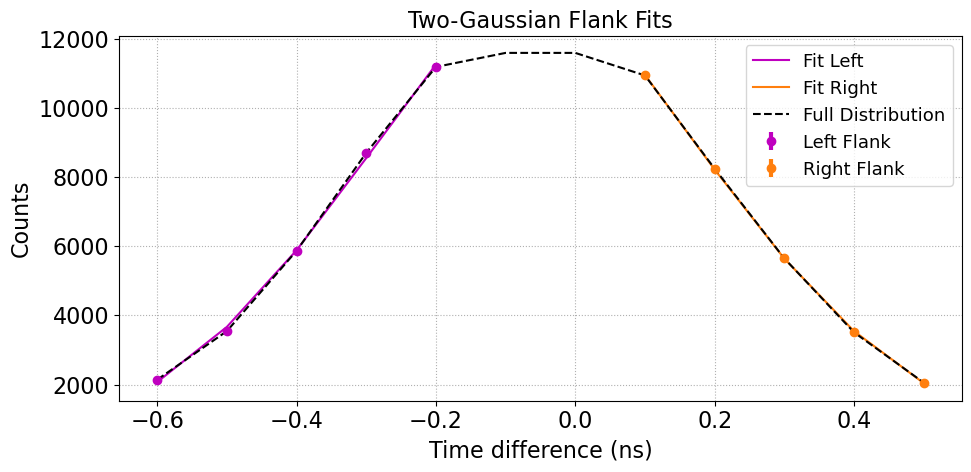

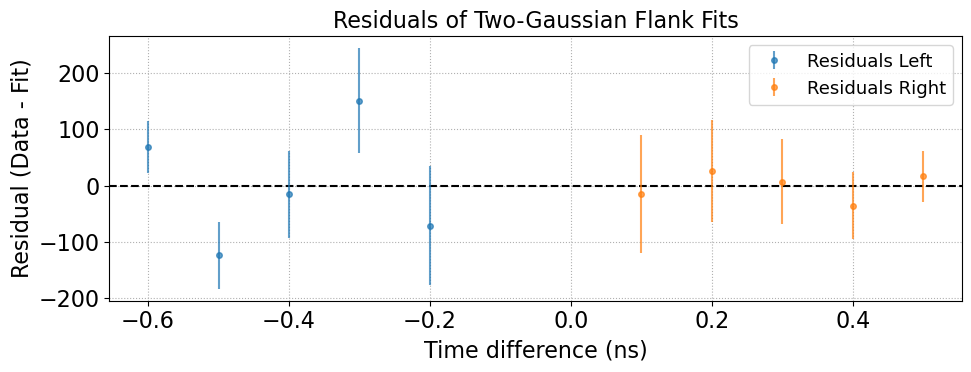

✅ Run 771: σ = 0.3273 ± 0.0095 ns
📁 Saved to timing_resolution_results_771.csv

=== Processing Run 772: dltdc16_sc02_t_02_10_ns_cut_twc ===
--- Two-Gaussian Flank Fit ---
Left  σ = 0.3119 ± 0.0144, χ²/ν = 3.29
Right σ = 0.3169 ± 0.0158, χ²/ν = 3.44

Average Timing Resolution: σ = 0.3144 ± 0.0107 ns


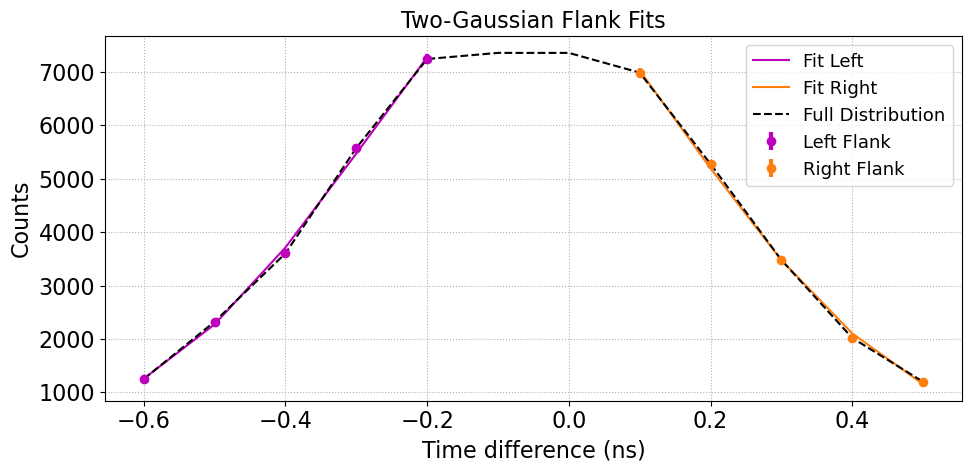

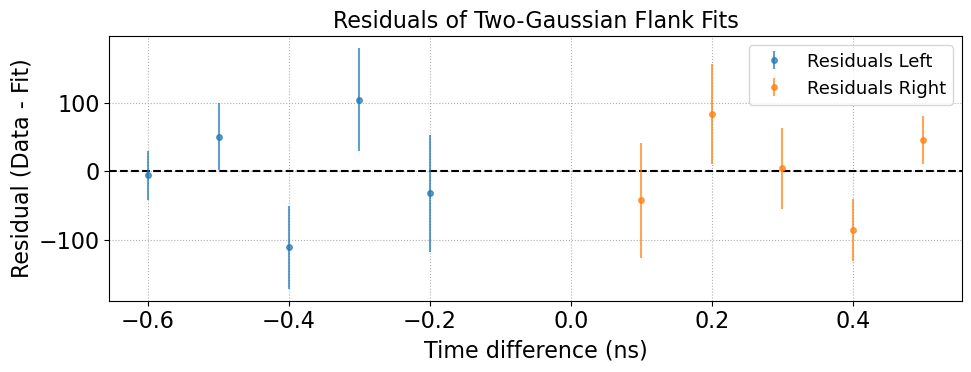

✅ Run 772: σ = 0.3144 ± 0.0107 ns
📁 Saved to timing_resolution_results_772.csv
❌ Error processing run 773: [Errno 2] No such file or directory: 'C:/Users/sidne/DarkLight 2025/output00773.root'

=== Processing Run 774: dltdc16_sc02_t_02_10_ns_cut_twc ===
--- Two-Gaussian Flank Fit ---
Left  σ = 0.2803 ± 0.0069, χ²/ν = 4.87
Right σ = 0.2836 ± 0.0103, χ²/ν = 0.61

Average Timing Resolution: σ = 0.2819 ± 0.0062 ns


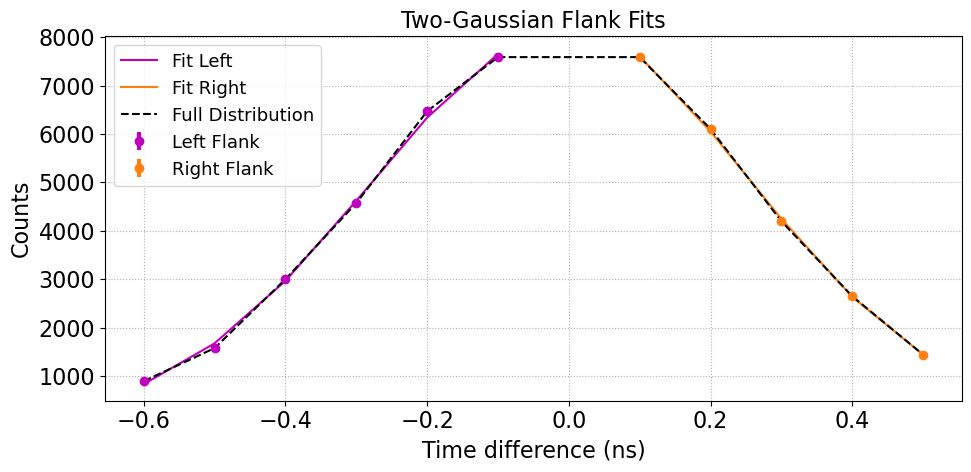

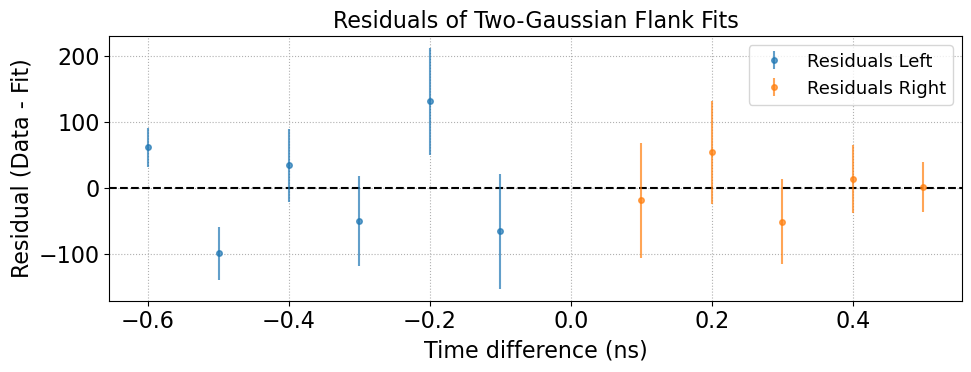

✅ Run 774: σ = 0.2819 ± 0.0062 ns
📁 Saved to timing_resolution_results_774.csv

=== Processing Run 775: dltdc16_sc02_t_02_10_ns_cut_twc ===
--- Two-Gaussian Flank Fit ---
Left  σ = 0.3671 ± 0.0236, χ²/ν = 4.08
Right σ = 0.3014 ± 0.0129, χ²/ν = 0.06

Average Timing Resolution: σ = 0.3343 ± 0.0134 ns


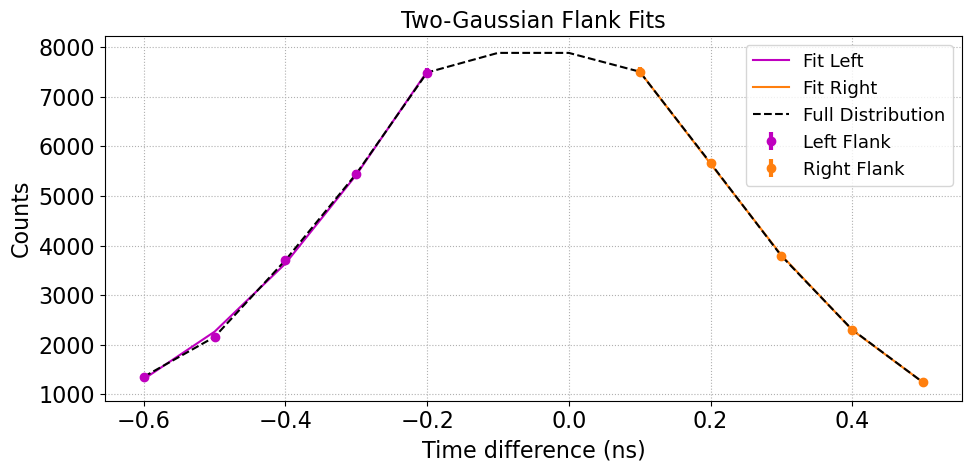

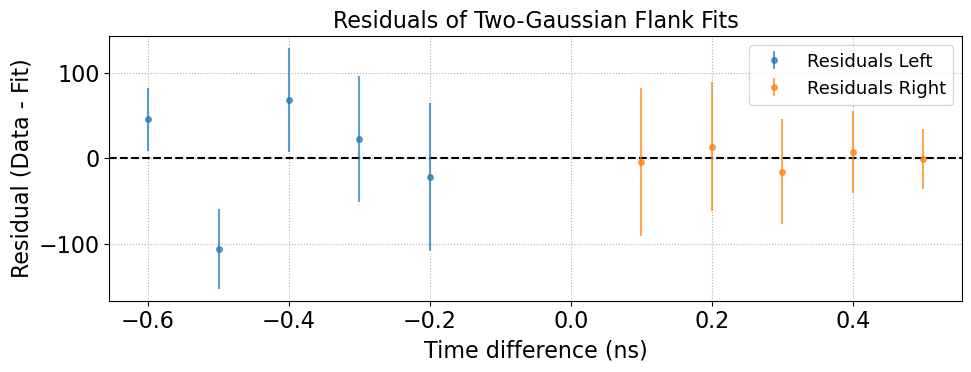

✅ Run 775: σ = 0.3343 ± 0.0134 ns
📁 Saved to timing_resolution_results_775.csv

=== Processing Run 776: dltdc16_sc02_t_02_10_ns_cut_twc ===
--- Two-Gaussian Flank Fit ---
Left  σ = 0.3176 ± 0.0110, χ²/ν = 1.15
Right σ = 0.3219 ± 0.0116, χ²/ν = 0.56

Average Timing Resolution: σ = 0.3197 ± 0.0080 ns


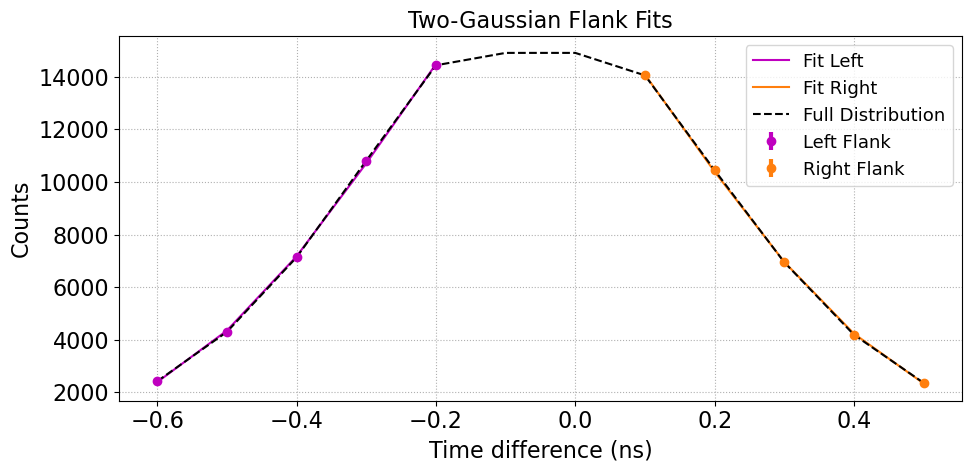

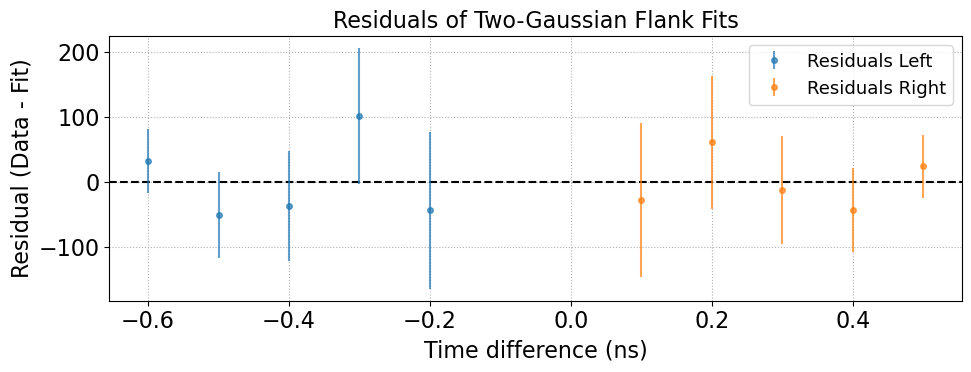

✅ Run 776: σ = 0.3197 ± 0.0080 ns
📁 Saved to timing_resolution_results_776.csv

=== Final Timing Resolution Data ===
time_res = [0.3273, 0.3144, 0.2819, 0.3343, 0.3197]
time_res_u = [0.0095, 0.0107, 0.0062, 0.0134, 0.008]


In [8]:
import numpy as np
import pandas as pd
import uproot

# Placeholder: define or import your fitting functions before running this
# - auto_fit_two_flanks_gaussian
# - get_flank_mask_slope_based
# - fit_two_flanks_gaussian

run_numbers = range(771, 777)
time_res_all = []
time_res_u_all = []

for runNumber in run_numbers:
    histogram_names = ["dltdc16_sc02_t_02_10_ns_cut_twc"]
    results = []
    buffer_bins = 0
    rootPath = "/Users/sidne/DarkLight 2025/"

    threshold = 0.1
    root_file_path = f"{rootPath}output{runNumber:05d}.root"

    try:
        with uproot.open(root_file_path) as f:
            folder = "dltdc16"
            for fileID in histogram_names:
                print(f"\n=== Processing Run {runNumber}: {fileID} ===")
                timeDiff = f[folder][fileID].to_numpy()[0]
                x_root = f[folder][fileID].to_numpy()[1][:-1]

                if np.sum(timeDiff) == 0:
                    print(f"⚠️ Skipping {fileID}: histogram is empty.")
                    continue

                global_max = np.max(timeDiff)
                first = next((i for i, y in enumerate(timeDiff) if y > threshold * global_max), None)
                last = next((i for i, y in enumerate(timeDiff[::-1]) if y > threshold * global_max), None)
                last = len(timeDiff) - 1 - last if last is not None else None

                if first is None or last is None:
                    print(f"⚠️ Skipping {fileID}: Could not find threshold crossings.")
                    continue

                x_root_cut = x_root[first:last + 1]
                timeDiff_cut = timeDiff[first:last + 1]
                y_err_cut = np.sqrt(np.clip(timeDiff_cut, 1, None))
                peakHeight = max(timeDiff_cut)
                countsChopped_cut = np.minimum(timeDiff_cut, (1 - threshold) * peakHeight)

                result = auto_fit_two_flanks_gaussian(
                    x_root_cut,
                    countsChopped_cut,
                    initial_thresh=0.025,
                    buffer_bins=buffer_bins,
                    max_iterations=30,
                    verbose=False
                )

                if result[0] is not None:
                    _, _, sigma_avg, chi2red, best_thresh = result

                    flank_mask = get_flank_mask_slope_based(
                        x_root_cut, countsChopped_cut,
                        buffer_bins=buffer_bins,
                        slope_threshold_frac=best_thresh
                    )
                    x_flank_g = x_root_cut[flank_mask]
                    y_flank_g = countsChopped_cut[flank_mask]

                    sigma_avg, sigma_avg_err, sigma_l, sigma_err_l, chi2red_l, sigma_r, sigma_err_r, chi2red_r = fit_two_flanks_gaussian(
                        x_flank_g, y_flank_g, return_all=True
                    )

                    results.append([
                        fileID,
                        sigma_avg, sigma_avg_err,
                        sigma_r, sigma_err_r, chi2red_r,
                        sigma_l, sigma_err_l, chi2red_l
                    ])

                    time_res_all.append(sigma_avg)
                    time_res_u_all.append(sigma_avg_err)

                    print(f"✅ Run {runNumber}: σ = {sigma_avg:.4f} ± {sigma_avg_err:.4f} ns")
                else:
                    print(f"❌ No acceptable fit found for {fileID}")

        # Save to CSV
        df = pd.DataFrame(results, columns=[
            "File Name",
            "σ_avg", "σ_avg_err",
            "σ_r", "σ_r_err", "χ²/ν_r",
            "σ_l", "σ_l_err", "χ²/ν_l"
        ])
        df.to_csv(f"timing_resolution_results_{runNumber}.csv", index=False)
        print(f"📁 Saved to timing_resolution_results_{runNumber}.csv")

    except Exception as e:
        print(f"❌ Error processing run {runNumber}: {e}")
        continue

# Print final vectors
print("\n=== Final Timing Resolution Data ===")
print("time_res =", [round(x, 4) for x in time_res_all])
print("time_res_u =", [round(x, 4) for x in time_res_u_all])



### Only use this when you want general ideas on how to fit a bunch of files. Once you select a optimal threshold usally just run it again with that threshold on the main fit function